# ProjE阅读笔记

## 1 背景介绍
**目的**：KG补全

为何需要补全：KGs are widely used for many practical tasks, however, their correctness and completeness are not guaranteed. Therefore, it is necessary to develop *knowledge graph completion*(KGC) methods to find missing or errant(不定的、错误的) relationships **with the goal of improving the general quality of KGs**.

$$
\text{KGC task} \left\{\begin{array}{l}
    \text{entity prediction} \left\{\begin{array}{l}
        \text{input:} <h,r,?> or <?,r,t> \\
        \text{output: a ranked list of candidate entities}
    \end{array}\right. \\
    \text{relationship prediction} \left\{\begin{array}{l}
        \text{input:} <h,?,t> \\
        \text{output: a ranked list of relationships that connect a head-entity wiith a tail-entity}
    \end{array}\right.
\end{array}\right.
$$

## 2 ProjE模型
背后意图：将prediction task看作一个排名问题，排名越高，预测约可靠
### 2.1 模型架构
ProjE是一个两层的神经网络，第一层是“combination layer”，第二层是“projection layer”，它是基于close world的模型，可解决entity、relationship prediction问题。下面的阐述是基于entity prediction，relation prediction的与之类似。

第一层对应的式子如下：

$$
\begin{array}{l}
\bf{z_1}=\bf{e}\bigoplus\bf{r}=\bf{D_e}\bf{e}+\bf{D_r}\bf{r}+\bf{b_c} \\
\bf{a_1}=\mathcal{f}(z_1)
\end{array}\tag{1}
$$

其中$\bf{D_e},\bf{D_r} \in R^{k×k};\bf{e,r,b_c} \in R^k$依次为实体权值矩阵、关系权值矩阵、实体embedding、关系embedding和组合误差，$k$为embeddings的维度，$\bf{e,r}$即为该层的输入，对应三元组$<?,r,e>$ or $<e,r,?>$，$\mathcal{f}$为激活函数

第二层对应式子如下：

$$
\begin{array}{l}
\bf{z_2}=\bf{W^c}\bf{a_1}+\rm{b_p} \\
\bf{a_2}=\mathcal{g}(z_2) \\
\rm{h}(\bf{e,r})=\bf{a_2}
\end{array}\tag{2}
$$

其中$\bf{W^c} \in R^{s×k}$为candidate-entity matrix，$s$为candidate实体的个数，$b_p \in R$为误差项，$\mathcal{g}$为激活函数，$a_2 \in R^s$即为获选实体的得分向量，每一项对应一个候选实体，分数越高排名越高。

注意，$\bf{e,W^c}$均来自$\bf{W^E} \in R^{|E_e|×k}$，$\bf{r}$来自$\bf{W^r} \in R^{|E_r|×k}$。

ProjE的架构图如下：

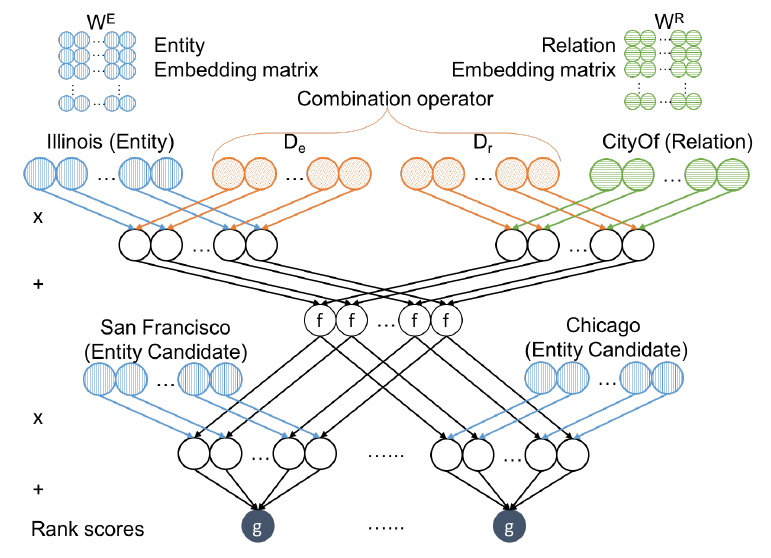

### 2.2 得分函数 and 损失函数
训练时，将该问题视为二分类问题
#### (1) ProjE_pointwise
**激活函数$\mathcal{g}$取 sigmoid，$\mathcal{f}$取 tanh**

注意，下面的$\bf{y} \in R^s$，而$\bf{y}_i$表示第$i$个 candidate 属于类别 0/1 的概率

损失函数：
$$
\mathcal{L}(\bf{e,r,y})=-\left(\sum_{i \in \left\{i|y_i=1\right\}}\log{\rm{h}(\bf{e,r})_i}+\sum_{i \in \left\{i|y_i=0\right\}}\log{\left(1-\rm{h}(\bf{e,r})_i\right)}\right)\tag{3}
$$
得分函数：
$$
\rm{h}(\bf{e,r})_i=\rm{sigmoid}\left(\bf{W^c_{[i,:]}}\rm{tanh}(\bf{e \bigoplus r})+\rm{b_p}\right)\tag{4}
$$
#### (2) ProjE_listwise
**激活函数$\mathcal{g}$取 softmax，$\mathcal{f}$取 tanh**

损失函数：
$$
\mathcal{L}(\bf{e,r,y})=-\sum_i^{|\bf{y}|}\frac{1(y_i=1)}{\sum_i1(y_i=1)}\log{(\rm{h}\left(\bf{e,r})_i\right)}\tag{5}
$$
得分函数：
$$
\rm{h}(\bf{e,r})_i=\frac{\exp\left(\bf{W^c_{[i,:]}}\rm{tanh}(\bf{e \bigoplus r})+\rm{b_p}\right)}{\sum_j\exp\left(\bf{W^c_{[j,:]}}\rm{tanh}(\bf{e \bigoplus r})+\rm{b_p}\right)}\tag{6}
$$

注意到公式（5），从表面上看，它似乎仅考虑正样本而忽略了负样本，最小化该代价函数，其实就是最大化正样本的得分$\rm{h}(\bf{e,r})_i$，而并未对负样本做任何“惩罚”。但其实不然，从公式（6）可以看出，正样本和负样本的$\rm{h}(\bf{e,r})_i$的总和为1，也就是说，若正样本的$\rm{h}(\bf{e,r})_i$最大化，那么负样本的$\rm{h}(\bf{e,r})_i$自然就会最小化，故该损失函数均考虑了正负样本。

## 3 模型理解
projE模型解决的是close world中的entity prediction和relationship prediction问题。它其实就是一个两层的神经网络，将KG补全问题视为一个排名问题。例如，对于一个三元组<?,r,t>，其中r,t是已知，而h未知，为‘？’。该模型将r和t作为输入，而其输出就是对所有候选值h的评分，评分越高排名就越高，则说明该预测约可靠。

projE模型的第一层神经网络对应公式（3），第二层神经网络对应公式（4），其中公式中的 $e$ 和 $r$ 即对应上述例子中的 t 和 r，$a_2$ 即为上述例子的对候选值 h 的“评分”，而 $W^c$ 是由所有候选者h的集合，即 $W^c$ 的每个行向量依次对应每个候选值 h。

在训练该模型时，是将这个问题视作一个二分类问题来处理的，也就是说，该模型的训练集包含标签为0/1的两种三元组，标签为1即表示该三元组是包含在KG中的，而标签为0则是由人为构造出的并未出现在KG中的三元组。

## 4 困惑
个人觉得想要将之套入算法框架，难度有点大，目前还没有头绪，下次讨论的时候再找师兄问问看。

之所以觉得有点难实现，主要是在算法框架中，要利用到已经学习到了的embeddings直接作为算法框架的输入。然而，经过projE模型学习后得到的embeddings，我个人感觉应该是无法直接利用的，也就是embeddings之间的关系不是明显的，它们要输入到projE后进行计算后才能明显的看出它们之间的关系，即embeddings对于projE而言是有意义的，脱离了projE，这些embeddings就是一些没有意义的向量（个人理解，不知道是不是正确），所以才感觉无法将至套入到算法框架中。